In [5]:
%matplotlib inline  

In [6]:
# %load "/home/yggdrasil/University/CEMRACS/horizontal_gene_transfer/FinalCode_Stochastic.py"
# Import packages here

import numpy as np
import scipy
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Auxiliary part
T_max= 10 #Maximal time
dT=1 #Step of discretization for time
nT=int(T_max/dT) #number of times
T=[t*dT for t in range(nT)] #list of all times

dT2=dT #interval of time for which events are taken into account

X_min = 0   # Minimal trait
X_max = 2   # Maximum amount of traits
dX = 0.1      # Step of discretization for time
nX = int((X_max-X_min)/dX) # number of traits
X = [x*dX for x in range(nX)] # list of possible traits

K = 1000    # Maximal capacity of the system
C = 0.5/K     # Competition
p = 0.3    # Probability of mutation
beta = 0    # 
mu = 1      # 
tau_const = 0.3   # parameter of a horizontal transfer

sigma = 0.1     # variance of the mutation kernel


#INITIAL TIME
N0=[0 for x in X]
Ntot0=1000  #initial size of population
N = np.zeros([nT,nX], dtype = int) # history of population sizes

m=1#Initial law of repartition. Gaussian centered at m with variance sigma0^2
sigma0=0.1
X_weighted= list(map(lambda z: np.exp(-((m-z)/sigma0)**2), X))
S=sum(X_weighted)
Initial_repartition=list(map(lambda z: z/S, X_weighted))    #law of repartition

def resc_x(x):#rescale a trait to a position in the vector X
    return int(x/dX)
    
x=np.random.choice(X, size=Ntot0, replace=True, p=Initial_repartition)#choice of Ntot random variable with respect to the law
for y in x:
    N0[resc_x(y)]+=1#creation of the vector of the initial population

N[0,] = N0

#################################################

#FUNCTION/PARAMETERS

def b(x):   # Birth rate function
    return 4-x

def d(x):   # Death rate function
    return 1

def death_prob(x, Ntot):
    # Ntot = total size of the population
    # C = Constant competition rate
    return d(x) + Ntot*C

# Compute the probability of birth, death and horizontal transfer events
    
def horizontal_transfer(x, y, Ntot):    # HT rate, i.e tau/(beta+mu*Ntot)
    if (x<y): 
        return tau_const/(beta+mu*Ntot)
    else:
        return 0

#Defining the events of death, birth, and HT

def death(n,x):#at time t, this function kills an individual x in the population n
    n[resc_x(x)]-=1#modifies in place


def mutation_kernel(x):#Define the mutation kernel centered at x
    X_weighted= list(map(lambda z: np.exp(-((x-z)/sigma)**2), X))
    S=sum(X_weighted)
    return list(map(lambda z: z/S, X_weighted))

def birth(n,x):#Process of birth of an individual x at time t in the population n
    mutation=np.random.binomial(1, p, size=None)==0#Boolean, true if mutation.
    if mutation:
        x_new=np.random.choice(X, size=None, replace=False, p=mutation_kernel(x))#choice of the new trait
        n[resc_x(x_new)]+=1 #new individual
    else:#If no mutation
         n[resc_x(x)]+=1


def HT_kernel(Ntot,x):#Defining the kernel of HT transfer
    X_weighted=list(map(lambda y: horizontal_transfer(x, y, Ntot), X))
    S=sum(X_weighted)
    return list(map(lambda z: z/S, X_weighted))


def HT(n,Ntot,x):#in a population n, with Ntot total individuals, at time t and individual with trait x is subject to a Horizontal transfer
    x_new=np.random.choice(X, size=None, replace=False, p=HT_kernel(Ntot,x))
    n[resc_x(x_new)]+=1
    n[resc_x(x)]-=1

def event_individual(n,Ntot,x):    #for a fixed individual (with trait x at time t in the population n) pick three times (T_b, T_d, T_HT) with the exponential law (lambda_b, lambda_d, lambda_HT) corresponding to the events of death, birth and HT. We only keep the first event (i.e the minimal time), and we return the time and type fof the first event.
    HT_tot=0   #We compute the total transfer rate, i.e the sum over y of tau(x,y)/(beta+mu*Ntot)
    for y in range(nX):
        HT_tot+=horizontal_transfer(x, y, Ntot)
    
    lambda_x_tot=b(x)+death_prob(x, Ntot)+HT_tot  #Total lambda   
    
    lambda_b = b(x)/lambda_x_tot
    lambda_d = death_prob(x, Ntot)/lambda_x_tot
    lambda_HT = HT_tot/lambda_x_tot #we recover the parameters of the exponential laws
    T_b, T_d, T_HT=np.random.exponential(scale=1/lambda_b, size=None), np.random.exponential(scale=1/lambda_d, size=None),np.random.exponential(scale=1/lambda_HT, size=None)#Compute the three random times
    T_first= min(T_b,T_d,T_HT)    #taking the first event
    Type_Event='birth'            #determining what kind of event the first event is.
    if T_d==T_first:
        Type_Event='death'
    elif T_HT==T_first:
        Type_Event='HT'
    return T_first,Type_Event

def event_collection(n,Ntot):  #for each individual in population n, we simulate the first event. Then we return the list of all the events for all individuals that happen bedore dT2.
    dT2=dT #interval of time in which events are taken into account.
    collection=pd.DataFrame(columns=['Time','Event','Trait'])
    for x in X:#for each trait
        for i in range(n[resc_x(x)]):  #for each individual of trait x
            T_first,Type_Event=event_individual(n,Ntot,x)  #we recover the first event of this individual
            collection=collection.append(pd.DataFrame([[T_first, Type_Event,x]], columns=['Time','Event','Trait']))#We add the new row with the new event
    return collection.loc[collection['Time']<dT2] #return the list with only times that are < dT2.


def event_collection_noloop(n,Ntot):  #for each individual in population n, we simulate the first event. Then we return the list of all the events for all individuals that happen bedore dT2.
    dT2=dT #interval of time in which events are taken into account.
    collection=pd.DataFrame(columns=['Time','Event','Trait'])
    T_first, Type_Event = list(map(lambda z: event_individual(n,Ntot, z), X))
    collection=collection.append(pd.DataFrame([[T_first, Type_Event,x]], columns=['Time','Event','Trait']))#We add the new row with the new event
 
    for x in X:#for each trait
        for i in range(n[resc_x(x)]):  #for each individual of trait x
            T_first,Type_Event=event_individual(n,Ntot,x)  #we recover the first event of this individual
            collection=collection.append(pd.DataFrame([[T_first, Type_Event,x]], columns=['Time','Event','Trait']))#We add the new row with the new event
    return collection.loc[collection['Time']<dT2] #return the list with only times that are < dT2.


def next_time(n):
    Ntot=sum(n)
    n_new=n.copy()
    events=event_collection(n,Ntot)
    for columns,row in events.iterrows():
        if row['Event']=='death':
            death(n_new,row['Trait'])
        elif row['Event']=='birth':
            birth(n_new,row['Trait'])
        else:
            HT(n_new,Ntot,row['Trait'])
    return n_new


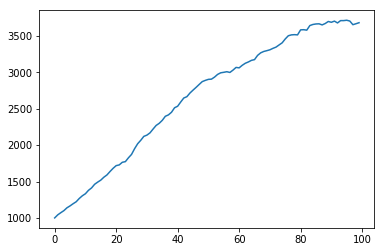

In [2]:
for t in range(0, nT-1):
    N[t+1] = next_time(N[t])
plt.plot(np.sum(N, axis = 1))

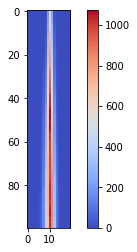

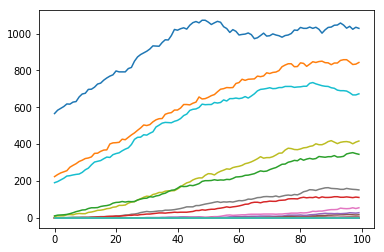

In [5]:
from pylab import imshow, colorbar, cm, show
im = imshow(N,cmap=cm.coolwarm) # drawing the function
colorbar(im) 
show()
plt.plot(N)

In [72]:
n = N[1]
Ntot = sum(N[1])
collection=pd.DataFrame(columns=['Time','Event','Trait'])
for x in X:#for each trait
    for i in range(n[resc_x(x)]):  #for each individual of trait x
        T_first,Type_Event=event_individual(n,Ntot,x)  #we recover the first event of this individual
        collection=collection.append(pd.DataFrame([[T_first, Type_Event,x]], columns=['Time','Event','Trait']))#We add the new row with the new event
smth = collection.loc[collection['Time']<dT2]

lambda_b, lambda_d, lambda_HT=flambda(n,Ntot,x)  #we recover the parameters of the exponential laws
T_b, T_d, T_HT=np.random.exponential(scale=1/lambda_b, size=None), np.random.exponential(scale=1/lambda_d, size=None),np.random.exponential(scale=1/lambda_HT, size=None)#Compute the three random times
T_first= min(T_b,T_d,T_HT)    #taking the first event
Type_Event='birth'            #determining what kind of event the first event is.
if T_d==T_first:
    Type_Event='death'
elif T_HT==T_first:
        Type_Event='HT'

In [73]:
print(lambda_b, lambda_d, lambda_HT)

0.04320460125612121 0.9566733135283984 0.00012208521548040538
